# Graphiques for article

## load data and packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from statannotations.Annotator import Annotator
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times, restricted_mean_survival_time

In [2]:
df = pd.read_excel("./data/df_long_format_for_analysis.xlsx",index_col=0)

In [3]:
df

,ID_Experiment,Mouse_ID,Date,Infection,Group,exp,survival_original,t_origin,Time,weight
0,ID_001,TRO-05432,2014-06-05,C. albicans,1A,1,1,9.0,Tinfection,100.0
1,ID_001,TRO-05433,2014-06-05,C. albicans,1A,1,1,9.0,Tinfection,100.0
2,ID_001,TRO-05434,2014-06-05,C. albicans,1A,1,1,9.0,Tinfection,100.0
3,ID_001,TRO-05435,2014-06-05,C. albicans,1A,1,1,6.0,Tinfection,100.0
4,ID_001,TRO-05456,2014-06-05,C. albicans,1A,1,1,7.0,Tinfection,100.0
...,...,...,...,...,...,...,...,...,...,...
32993,ID_096,TRO-028337,2023-03-03,S. pneumoniae,3,3,1,5.0,T13,NaN
32994,ID_096,TRO-028338,2023-03-03,S. pneumoniae,3,3,1,4.0,T13,NaN
32995,ID_096,TRO-028339,2023-03-03,S. pneumoniae,3,3,1,6.0,T13,NaN
32996,ID_096,TRO-028342,2023-03-03,S. pneumoniae,3,3,0,8.0,T13,NaN


### utils functions

In [4]:
def remove_outlier(df):
    dead = df[df['survival_original']==1]
    dead_listeria = dead[(dead['Infection']=='Listeria')& (dead['Time'] == 'T8')]
    dead_listeria_index = dead_listeria.dropna(subset=['weight'],inplace=False).index
    infection = df[df['Infection'].isin(["Listeria","S. pneumoniae"])]
    to_high_index = infection[(infection['weight']>112) & (infection['Time'].isin(["T1","T2","T3"]))].index
    to_low_index = infection[(infection['weight']<60)].index
    #to_remove = to_high_index + to_low_index
    weight_impossible_value = to_high_index.union(to_low_index)
    index_to_remove = dead_listeria_index.union(weight_impossible_value) 
    df_clean = df.drop(index_to_remove)
    return df_clean

In [5]:
def import_simulations(folder_name):
    All_names = os.listdir(folder_name)
    list_df = []
    for name in All_names:
        if name[-4:] != "xlsx":
            continue
        else:
            split_name = name.split('_')[0]
            df = pd.read_excel(folder_name+name,index_col=0)
            df['Infection'] = split_name
            list_df += [df]
    df = pd.concat(list_df,axis=0).reset_index(drop=True,inplace=False)
    return df

### cleaning df and renaming for better visulaisation

In [6]:
df_clean = remove_outlier(df)
status_mapping = {0: 'Alive', 1: 'Dead'}
df_clean["survival_original"] = df_clean['survival_original'].replace(status_mapping)

infection_mapping = {'Listeria':"L. monocytogenes"}
df_clean['Infection'] =df_clean['Infection'].replace(infection_mapping)

df_clean.rename(columns={'survival_original':'Mice'},inplace=True)

time_rename = list(np.arange(0,15,1))
time_unique = df_clean['Time'].unique()
time_mapping = dict(zip(time_unique,time_rename))
df_clean['Time'] = df_clean['Time'].replace(time_mapping)
df_clean


,ID_Experiment,Mouse_ID,Date,Infection,Group,exp,Mice,t_origin,Time,weight
0,ID_001,TRO-05432,2014-06-05,C. albicans,1A,1,Dead,9.0,0,100.0
1,ID_001,TRO-05433,2014-06-05,C. albicans,1A,1,Dead,9.0,0,100.0
2,ID_001,TRO-05434,2014-06-05,C. albicans,1A,1,Dead,9.0,0,100.0
3,ID_001,TRO-05435,2014-06-05,C. albicans,1A,1,Dead,6.0,0,100.0
4,ID_001,TRO-05456,2014-06-05,C. albicans,1A,1,Dead,7.0,0,100.0
...,...,...,...,...,...,...,...,...,...,...
32993,ID_096,TRO-028337,2023-03-03,S. pneumoniae,3,3,Dead,5.0,13,NaN
32994,ID_096,TRO-028338,2023-03-03,S. pneumoniae,3,3,Dead,4.0,13,NaN
32995,ID_096,TRO-028339,2023-03-03,S. pneumoniae,3,3,Dead,6.0,13,NaN
32996,ID_096,TRO-028342,2023-03-03,S. pneumoniae,3,3,Alive,8.0,13,NaN


### Kaplan meier plot

In [7]:
df_clean['t_origin'].max()

14.0

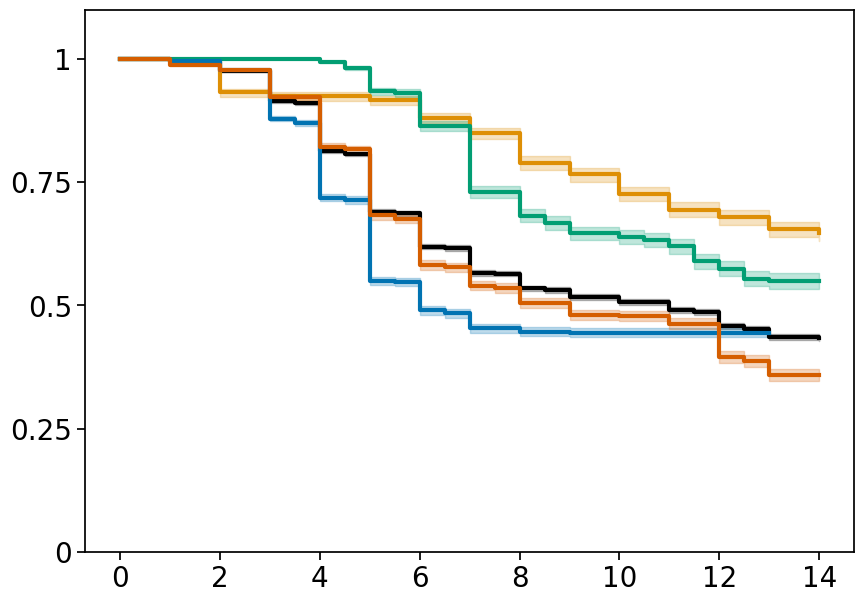

In [58]:
kmf = KaplanMeierFitter()
# A4 page dimensions in inches
a4_width_in_inches = 8.27
a4_height_in_inches = 11.69

# Calculate the width and height of the figure for a nice ratio
ratio = 1.41  # sqrt
fig_width = a4_width_in_inches * 1.2  # 80% of A4 width
fig_height = fig_width / ratio
plt.figure(figsize=(fig_width,fig_height))
ax = plt.subplot(111)
df_KP = df_clean.copy()
df_KP['Mice'] = df_KP['Mice'].replace({'Dead':1,'Alive':0})
palette = sns.color_palette("colorblind")
color_infection = {"C. albicans":1,"H1N1":2,"L. monocytogenes":0,"S. pneumoniae":3}

kmf.fit(df_KP["t_origin"], df_KP["Mice"],label='Total')
kmf.plot_survival_function(ax=ax,color="black")

for name, grouped_df in df_KP.groupby('Infection'):
    kmf.fit(grouped_df["t_origin"], grouped_df["Mice"],label=name)
    kmf.plot_survival_function(ax=ax,color=palette[color_infection[name]])


ytick_tick = [0,0.25,0.5,0.75,1]
ytick_label = [0,0.25,0.5,0.75,1]
plt.xticks( ha='center',fontsize=20)
plt.yticks(ytick_tick,ytick_label,fontsize=20)
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title("", fontsize=22)
plt.ylim(0, 1.1)
ax.get_legend().remove()
plt.savefig("./plots/kaplan_meier/all_mice.png")


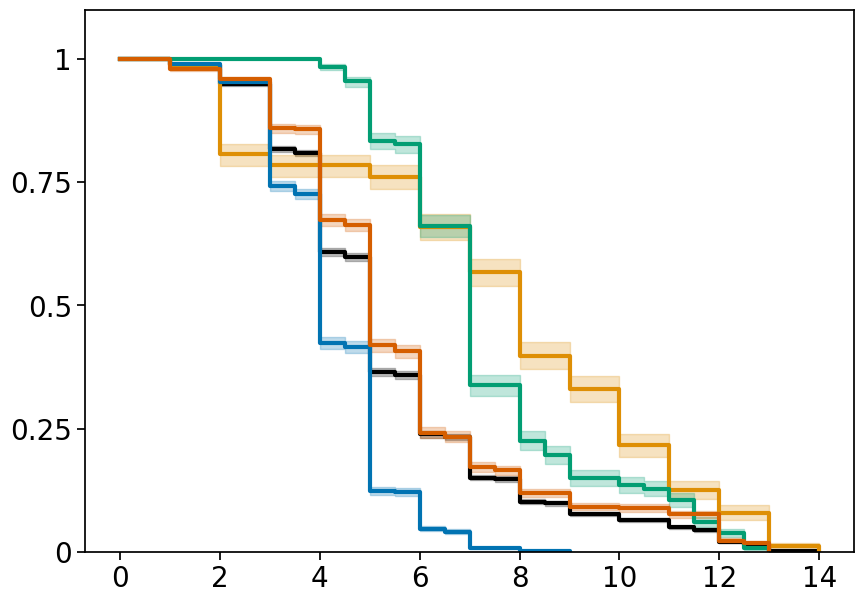

In [59]:
kmf = KaplanMeierFitter()
# A4 page dimensions in inches
a4_width_in_inches = 8.27
a4_height_in_inches = 11.69

# Calculate the width and height of the figure for a nice ratio
ratio = 1.41  # sqrt
fig_width = a4_width_in_inches * 1.2  # 80% of A4 width
fig_height = fig_width / ratio
plt.figure(figsize=(fig_width,fig_height))
ax = plt.subplot(111)
df_KP = df_clean.copy()
df_KP['Mice'] = df_KP['Mice'].replace({'Dead':1,'Alive':0})
df_dead = df_KP[df_KP['Mice']==1]

palette = sns.color_palette("colorblind")
color_infection = {"C. albicans":1,"H1N1":2,"L. monocytogenes":0,"S. pneumoniae":3}

kmf.fit(df_dead["t_origin"], df_dead["Mice"], label='Total')
kmf.plot_survival_function(ax=ax,color="black")

for name, grouped_df in df_dead.groupby('Infection'):
    kmf.fit(grouped_df["t_origin"], grouped_df["Mice"], label=name)
    kmf.plot_survival_function(ax=ax,color=palette[color_infection[name]])

ytick_tick = [0,0.25,0.5,0.75,1]
ytick_label = [0,0.25,0.5,0.75,1]
plt.xticks( ha='center',fontsize=20)
plt.yticks(ytick_tick,ytick_label,fontsize=20)
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title("", fontsize=22)
ax.get_legend().remove()
plt.ylim(0, 1.1)
plt.savefig("./plots/kaplan_meier/non_survivor_mice.png")

### Violin

In [10]:
def violin_plot(df,infection,max_time=10,save = False,path_to_save='',show=False,annotation=True):
    df_infection = df[df['Infection'] == infection]
    df_infection = df_infection[(df_infection['Time']>0) & (df_infection['Time']<=max_time)]
    
    # A4 page dimensions in inches
    a4_width_in_inches = 8.27
    a4_height_in_inches = 11.69

    # Calculate the width and height of the figure for a nice ratio
    ratio = 1.41  # sqrt
    fig_width = a4_width_in_inches * 1.2  # 80% of A4 width
    fig_height = fig_width / ratio

    
    palette = sns.color_palette("colorblind")
    #palette[0] = palette[2]
    
    #ANNOTATION
    pairs = [((n,'Alive'),(n,'Dead')) for n in df_infection.Time.unique()]
    fig, ax = plt.subplots(figsize=(fig_width,fig_height))

    sns.violinplot(data=df_infection,
    ax=ax,
    x='Time',y='weight',
    hue='Mice',
    cut=0.5,
    palette=palette,
    saturation=0.8,
    inner="point",
    hue_order=("Alive","Dead"),
    legend=False,
    density_norm='width')

    fig.subplots_adjust(bottom=0.15)  # Adjust the bottom margin
    
    if annotation:
        annotator = Annotator(ax, pairs, data=df_infection, x='Time', y='weight',hue='Mice')
        annotator.configure(test='Kruskal', text_format='star', loc='inside')
        annotator.apply_and_annotate()
    
    if infection == "H1N1":
        sns.despine()
        plt.xticks(fontsize=20)
    else:
        sns.despine(bottom=True)
        plt.xticks([],rotation=0, fontsize=20)
    
    plt.yticks(fontsize=20)
    plt.legend([],[], frameon=False)
    plt.xlabel('', fontsize=25)
    plt.ylabel('Percent of initial weight', fontsize=25)
    plt.title("",fontsize=10,style='italic')
    plt.ylim(55, 125)
    if save:
        plt.savefig(path_to_save+infection+".png")

    if show:
        plt.show()

C. albicans


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\722415156.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_infection,


L. monocytogenes


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\722415156.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_infection,


S. pneumoniae


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\722415156.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_infection,


H1N1


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\722415156.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_infection,


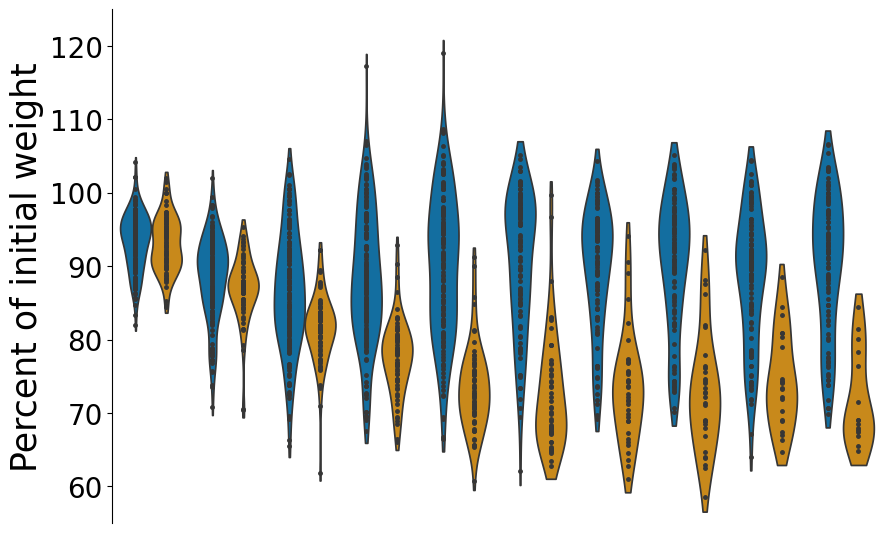

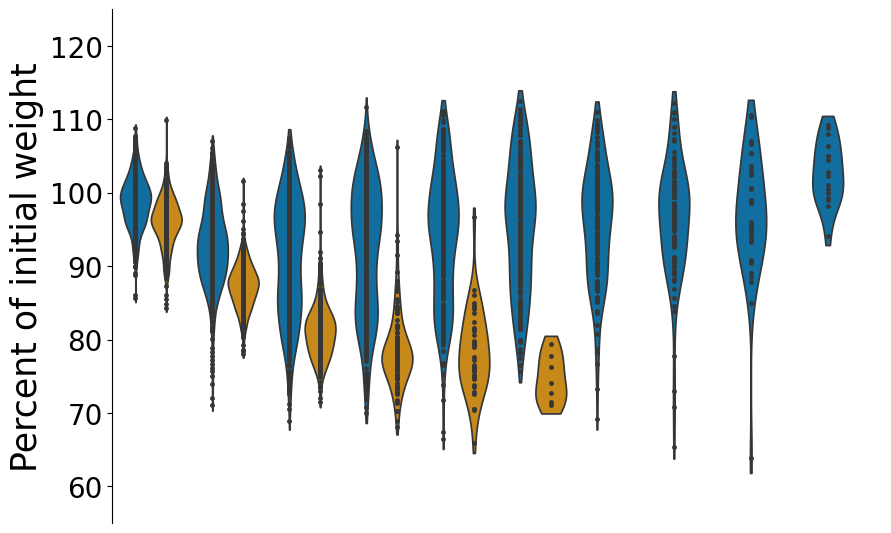

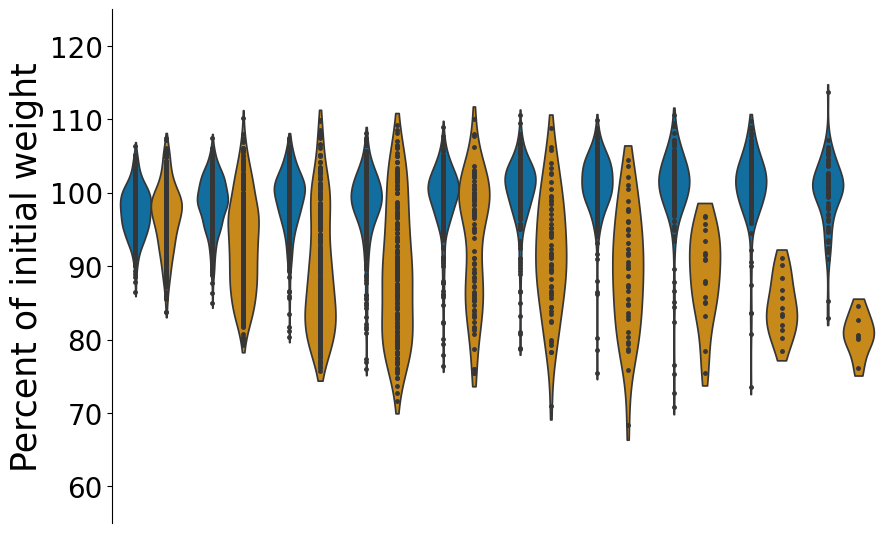

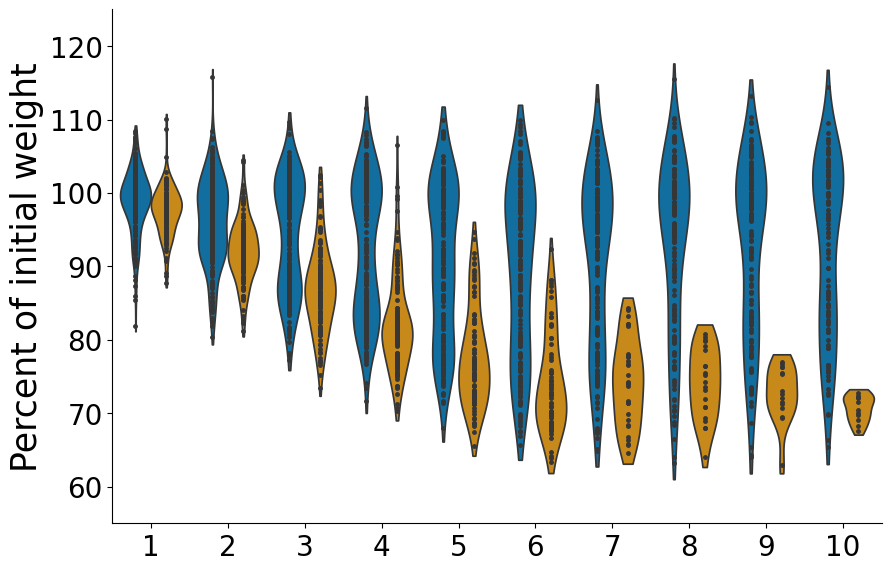

In [11]:
#violin_plot(df,'C. albicans',show=True)
path_to_save = "./plots/violin/"
for infection in df_clean['Infection'].unique():
    print(infection)
    violin_plot(df_clean,infection=infection,max_time=10,save=True,show=False,path_to_save='./plots/violin/',annotation=False)

In [12]:
def full_plot(df,max_time=10,save = False,path_to_save='',show=False,annotation=True):
       
    # A4 page dimensions in inches
    a4_width_in_inches = 8.27
    a4_height_in_inches = 11.69

    # Calculate the width and height of the figure for a nice ratio
    ratio = 1.41  # sqrt(2)
    fig_width = a4_width_in_inches * 3  # 80% of A4 width
    fig_height = fig_width / ratio

    hue_order = ("Alive","Dead")
    
    palette = sns.color_palette("colorblind")
    fig, axs = plt.subplots(4,2,figsize=( fig_height,fig_width))
    for index, infection in enumerate(df['Infection'].unique()):
        df_infection = df[df['Infection']==infection]
        df_violin = df_infection[(df_infection['Time']>0) & (df_infection['Time']<=max_time)]
        sns.violinplot(data=df_violin,ax=axs[index,0],x='Time',y='weight',hue='Mice',cut=0.5,palette=palette,saturation=0.8,inner="point",hue_order=hue_order,legend=False)
        sns.lineplot(data=df_infection,ax=axs[index,1],x = "Time",y = "weight",hue='Mice',errorbar=("sd"),err_style="band",hue_order=hue_order,legend=False, estimator=np.median,palette=palette)
    
    for ax in fig.get_axes():
        ax.label_outer()
    
    fig.savefig("./plots/total.png")
    

C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\1698699705.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_violin,ax=axs[index,0],x='Time',y='weight',hue='Mice',cut=0.5,palette=palette,saturation=0.8,inner="point",hue_order=hue_order,legend=False)
C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\1698699705.py:20: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_infection,ax=axs[index,1],x = "Time",y = "weight",hue='Mice',errorbar=("sd"),err_style="band",hue_order=hue_order,legend=False, estimator=np.median,palette=palette)
C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\1698699705.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_violin,ax=axs[index,0],x='Time',y='weight',hue='Mice',cut=0.5,palette=palette,saturation=0.8,inner="point",hue_order=hue_order,le

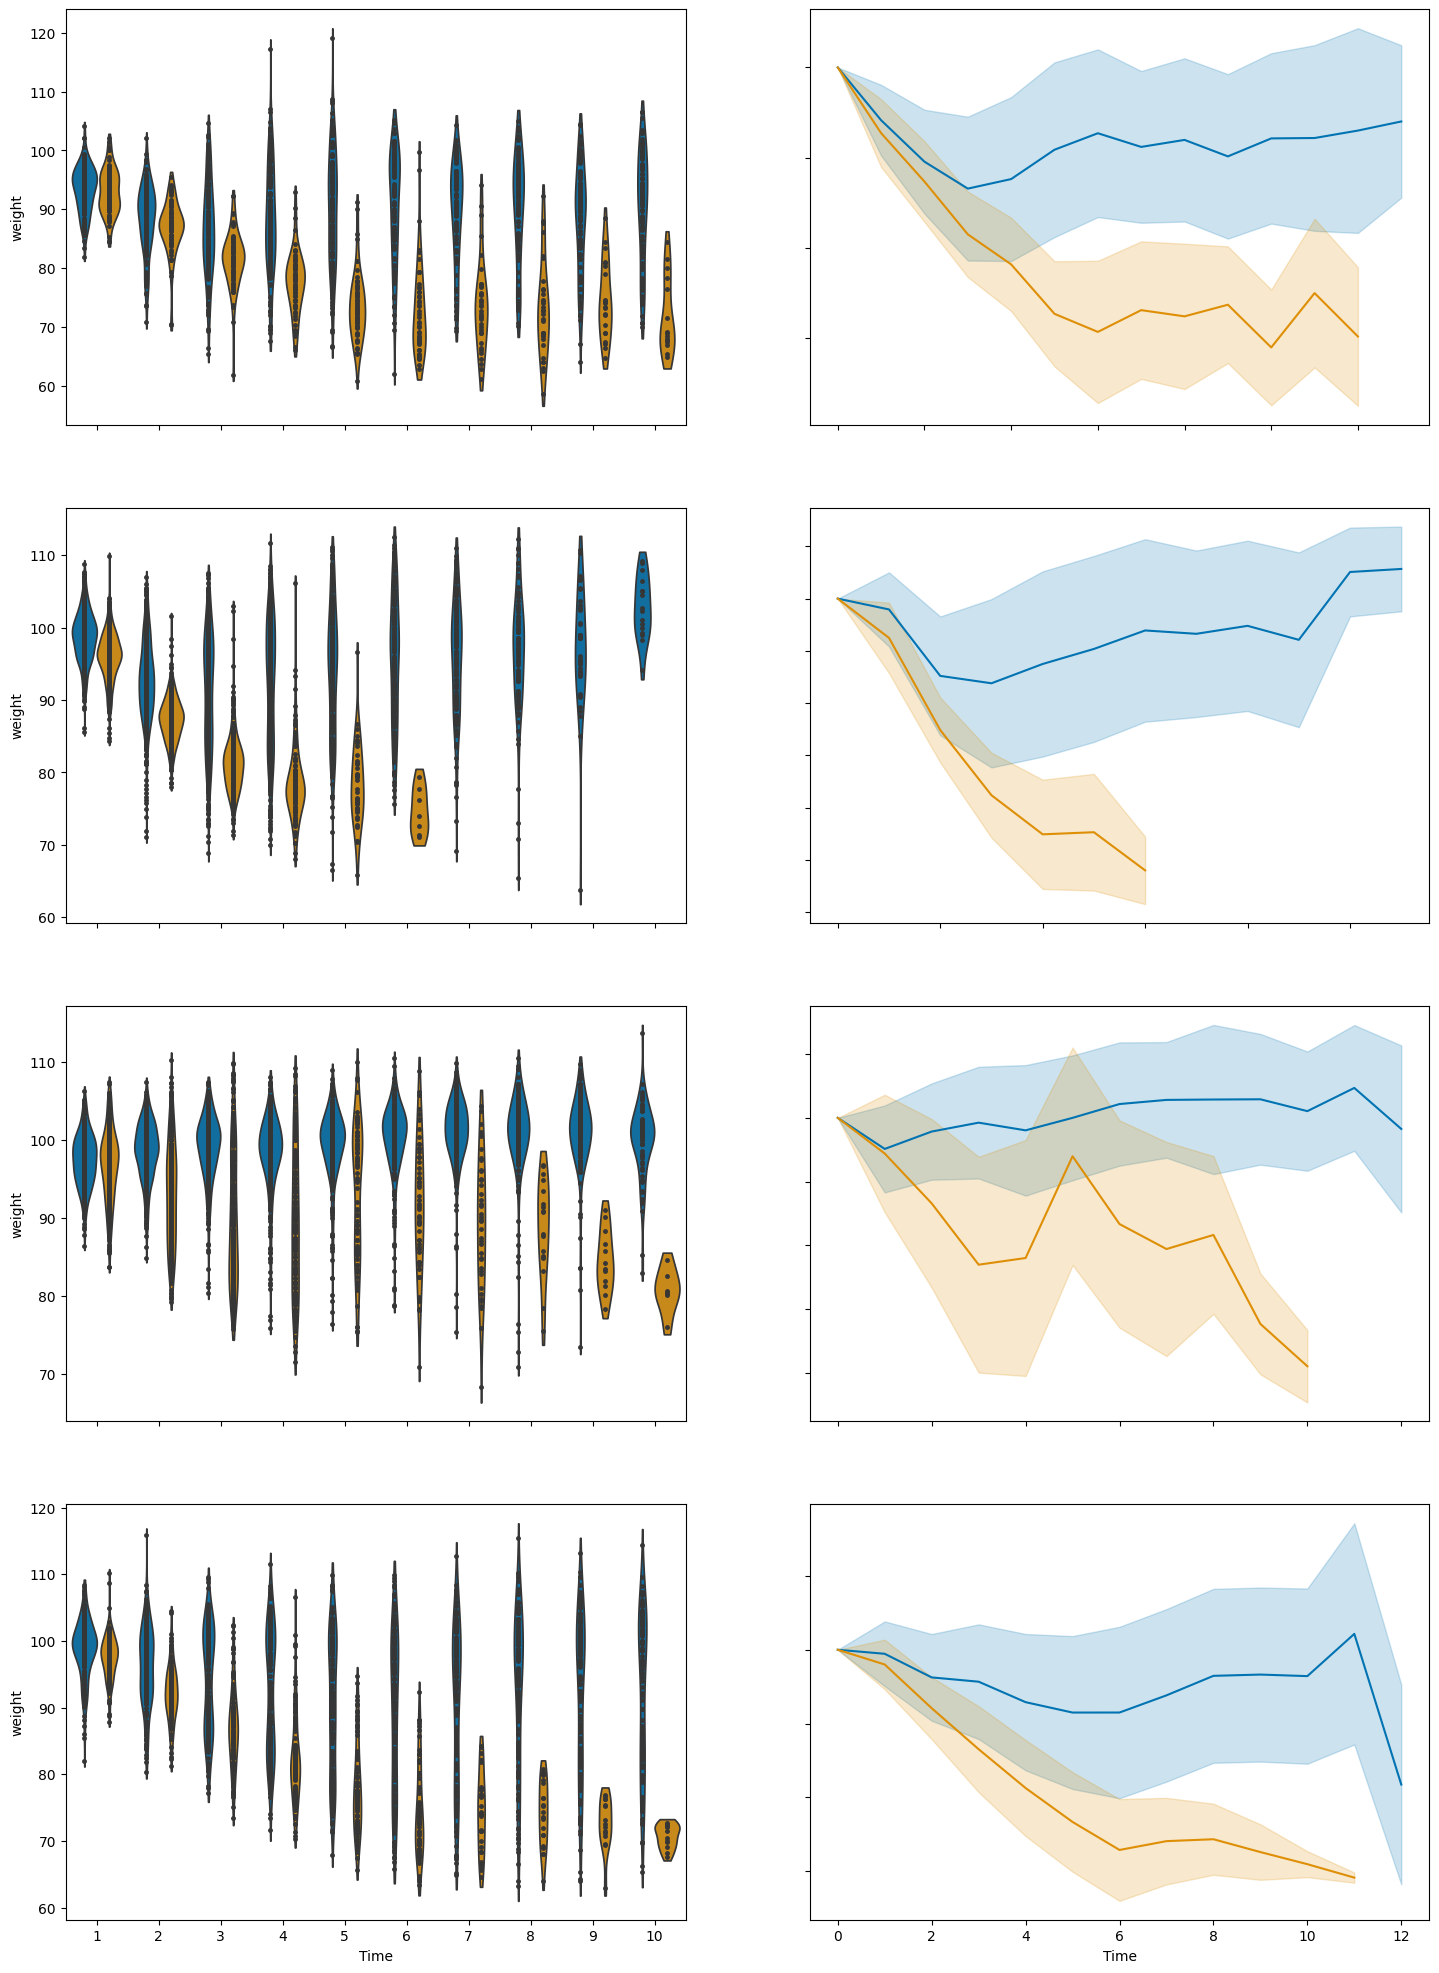

In [13]:
full_plot(df_clean)

### box plot

In [35]:
def boxplot_plot(df,infection,max_time=10,save = False,path_to_save='',show=False,annotation=True):
    df_infection = df[df['Infection'] == infection]
    df_infection = df_infection[(df_infection['Time']>0) & (df_infection['Time']<=max_time)]
    
    # A4 page dimensions in inches
    a4_width_in_inches = 8.27
    a4_height_in_inches = 11.69

    # Calculate the width and height of the figure for a nice ratio
    ratio = 1.618  # Golden ratio
    fig_width = a4_width_in_inches * 1  # 80% of A4 width
    fig_height = fig_width / ratio

    
    palette = sns.color_palette("colorblind")
    #palette[0] = palette[2]
    
    #ANNOTATION
    pairs = [((n,'Alive'),(n,'Dead')) for n in df_infection.Time.unique()]
    fig, ax = plt.subplots(figsize=(fig_width,fig_height))
    sns.violinplot(data=df_infection,ax=ax,x='Time',y='weight',hue='Mice',cut=0.3,palette=palette,saturation=0.8,inner="point",hue_order=("Alive","Dead"),legend=False)
    
    if annotation:
        annotator = Annotator(ax, pairs, data=df_infection, x='Time', y='weight',hue='Mice')
        annotator.configure(test='Kruskal', text_format='star', loc='inside')
        annotator.apply_and_annotate()
    
    
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend([],[], frameon=False)
    plt.xlabel('', fontsize=25)
    plt.ylabel('', fontsize=25)
    plt.title("",fontsize=10,style='italic')
    plt.ylim(55, 125)
    if save:
        plt.savefig(path_to_save+infection+".png")

    if show:
        plt.show()

C. albicans


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\925309209.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_infection,ax=ax,x='Time',y='weight',hue='Mice',cut=0.3,palette=palette,saturation=0.8,inner="point",hue_order=("Alive","Dead"),legend=False)


L. monocytogenes


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\925309209.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_infection,ax=ax,x='Time',y='weight',hue='Mice',cut=0.3,palette=palette,saturation=0.8,inner="point",hue_order=("Alive","Dead"),legend=False)


S. pneumoniae


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\925309209.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_infection,ax=ax,x='Time',y='weight',hue='Mice',cut=0.3,palette=palette,saturation=0.8,inner="point",hue_order=("Alive","Dead"),legend=False)


H1N1


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\925309209.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df_infection,ax=ax,x='Time',y='weight',hue='Mice',cut=0.3,palette=palette,saturation=0.8,inner="point",hue_order=("Alive","Dead"),legend=False)


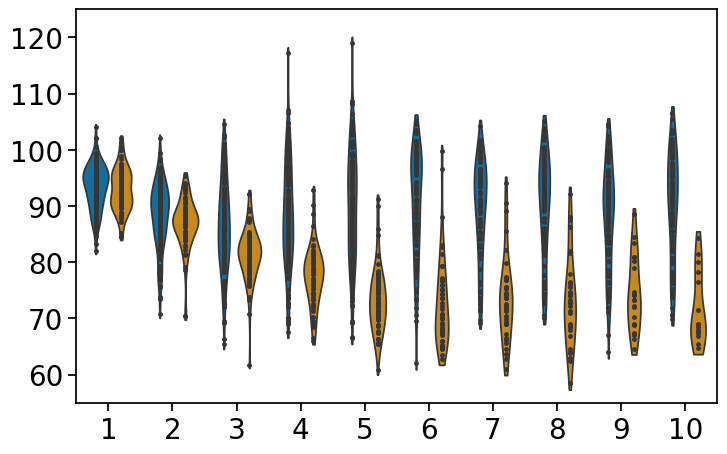

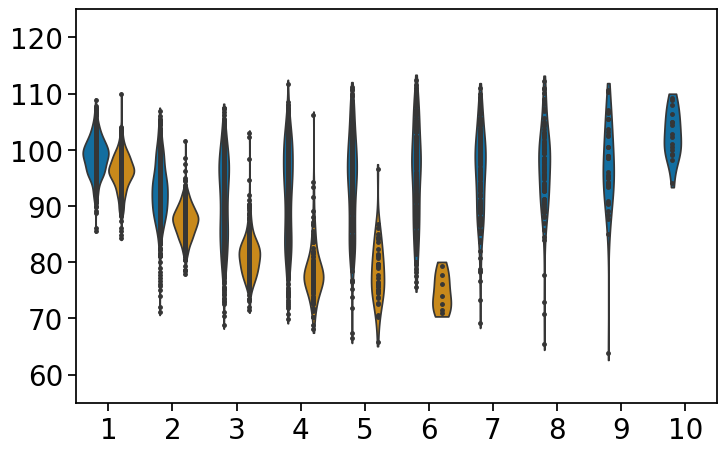

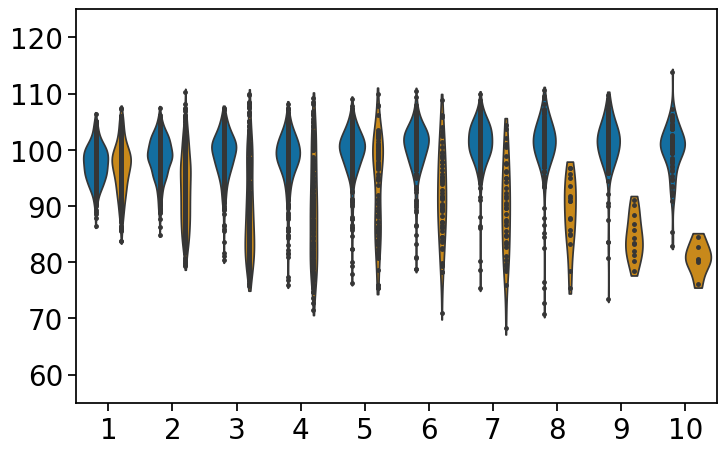

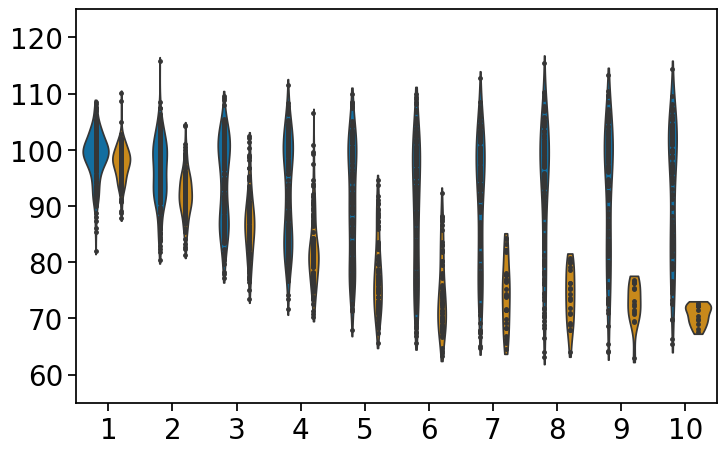

In [36]:
#violin_plot(df,'C. albicans',show=True)
path_to_save = "./plots/boxplot/"
for infection in df_clean['Infection'].unique():
    print(infection)
    boxplot_plot(df_clean,infection=infection,max_time=10,save=True,show=False,path_to_save=path_to_save,annotation=False)

### Median over time

In [37]:
def plot_weight_by_infection(df,infection="L. monocytogenes",group="Mice",plot = False,save = False,path_to_save = "weight_over_time.png",errorbar = ("ci"),max_time=14):
    df_infection = df[df['Infection'] == infection]
    df_infection = df_infection[(df_infection['Time']<=max_time)]

    hue_order = ['Alive','Dead']

    
    # A4 page dimensions in inches
    a4_width_in_inches = 8.27
    a4_height_in_inches = 11.69

    # Calculate the width and height of the figure for a nice ratio
    ratio = 1.41  # sqrt(2)
    fig_width = a4_width_in_inches * 1.2  # 80% of A4 width
    fig_height = fig_width / ratio

    plt.figure(figsize=(fig_width,fig_height))
    palette = sns.color_palette("colorblind")
    #palette[0] = palette[2]
    sns.set_context("notebook", rc={"lines.linewidth": 3})
    sns.lineplot(data=df_infection,x = "Time",y = "weight",hue=group,errorbar=errorbar,err_style="band",
     hue_order=hue_order,legend=False, estimator=np.median,palette=palette) #, estimator=np.median
    
    x_tick_label = [ n for n in range(max_time+1) ]
    #x_tick_label = [ '' for n in range(max_time+1) ]
    y_tick_label = [ '' for n in range(7) ]
    
    if infection == "H1N1":
        sns.despine()
        plt.xticks(ticks=range(0,max_time+1,1),labels=x_tick_label,rotation=0, fontsize=20)
    else:
        sns.despine(bottom=True,left=False)
        plt.xticks([])
    plt.yticks( fontsize=20)
    #plt.yticks(ticks=range(0,7,1),labels=['' for n in range(7)])
    plt.xlabel('', fontsize=25)
    plt.ylabel('', fontsize=25)
    plt.title("", fontsize=10,style='italic')
    plt.subplots_adjust(bottom=0.15)
    plt.ylim(55, 125)
    if plot:
        plt.show()
    if save:
        plt.savefig(path_to_save+infection+"dead_vs_alive"+".png")

C. albicans


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\631477077.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_infection,x = "Time",y = "weight",hue=group,errorbar=errorbar,err_style="band",


L. monocytogenes


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\631477077.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_infection,x = "Time",y = "weight",hue=group,errorbar=errorbar,err_style="band",


S. pneumoniae


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\631477077.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_infection,x = "Time",y = "weight",hue=group,errorbar=errorbar,err_style="band",


H1N1


C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\631477077.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_infection,x = "Time",y = "weight",hue=group,errorbar=errorbar,err_style="band",


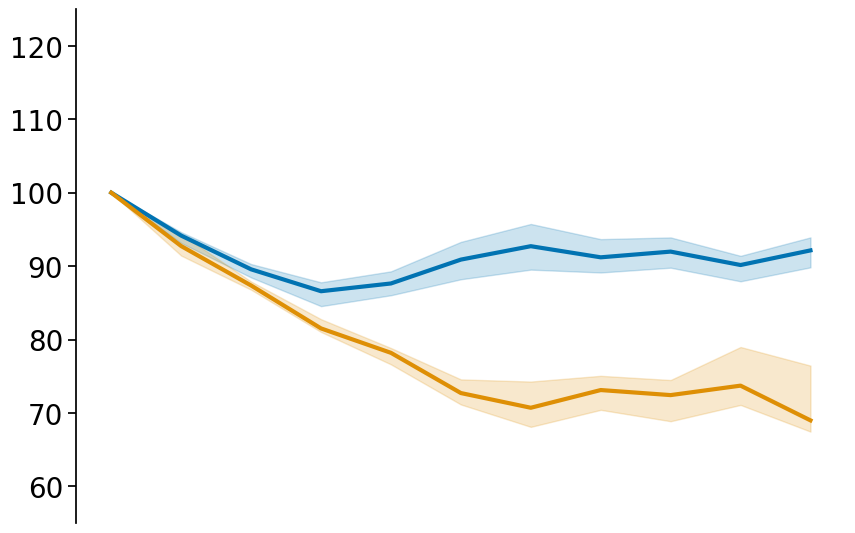

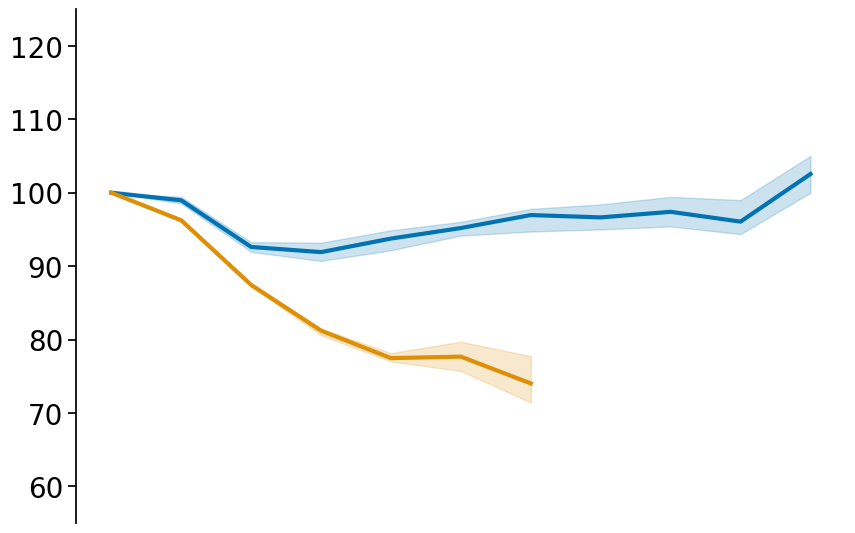

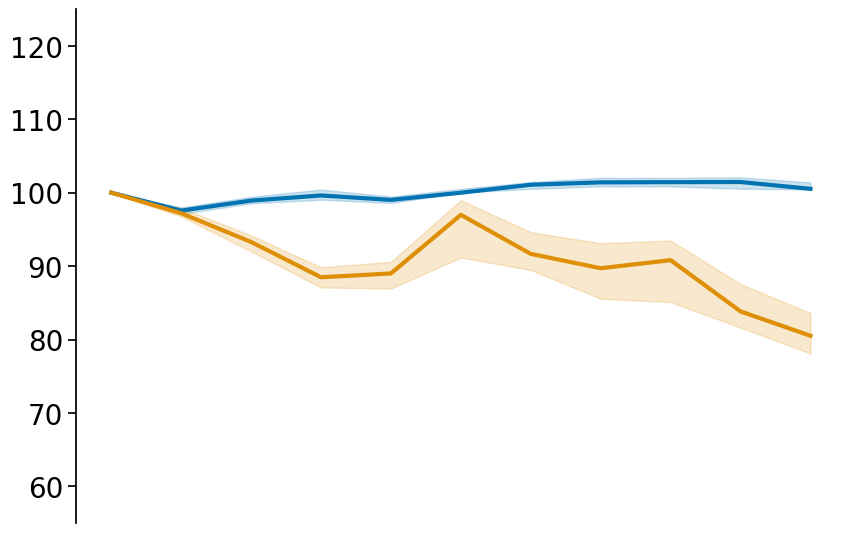

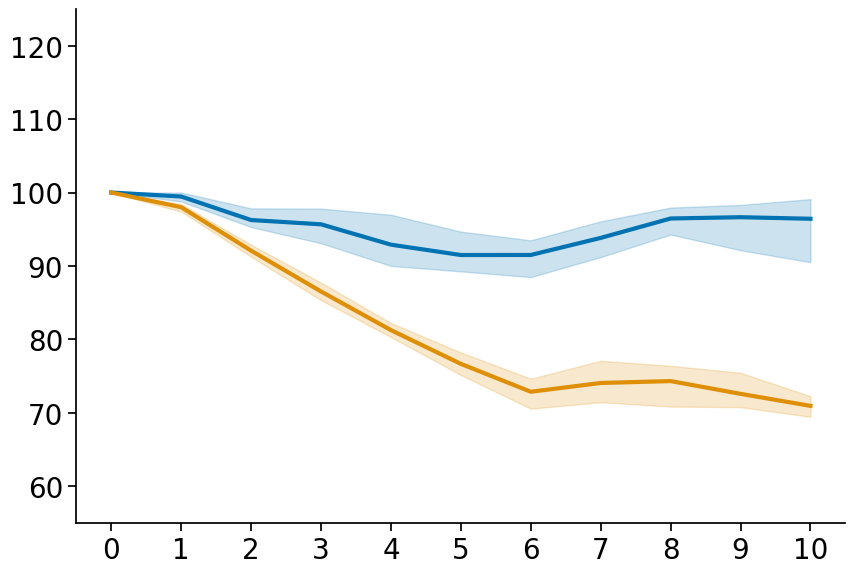

In [38]:
for infection in df_clean['Infection'].unique():
    print(infection)
    plot_weight_by_infection(df=df_clean,infection=infection,group='Mice',save=True,path_to_save='./plots/median/',max_time=10)

## In house Power

In [39]:
models = ['C. albicans','Listeria','S. pneumoniae',"H1N1"]
list_df = []
for model in models:
    path = f"./results/in_house/{model}.xlsx"
    print(path)
    df = pd.read_excel(path,index_col=0)
    list_df += [df]
power_in_house = pd.concat(list_df,keys=models)
power_in_house = power_in_house.reset_index().rename(columns={"level_0":"Infection","level_1":"Threshold"})
power_in_house

./results/in_house/C. albicans.xlsx
./results/in_house/Listeria.xlsx
./results/in_house/S. pneumoniae.xlsx
./results/in_house/H1N1.xlsx


,Infection,Threshold,count_p_values,number_of_experiment
0,C. albicans,original,4,10
1,C. albicans,0.3,4,10
2,C. albicans,0.29,4,10
3,C. albicans,0.28,4,10
4,C. albicans,0.27,4,10
...,...,...,...,...
103,H1N1,0.09,4,22
104,H1N1,0.08,4,22
105,H1N1,0.07,5,22
106,H1N1,0.06,5,22


In [40]:
power_in_house['Infection'] = power_in_house['Infection'].replace({"Listeria":"L. monocytogenes"})
power_in_house['Threshold'] = power_in_house['Threshold'].replace({"original":"raw data"})
infection_of_interest = ["L. monocytogenes","C. albicans","H1N1","S. pneumoniae"]

C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\2385146343.py:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(power_in_house,x="Threshold",y="count_p_values",hue="Infection",palette=palette,linewidth = 3,hue_order=infection_of_interest,legend=False)


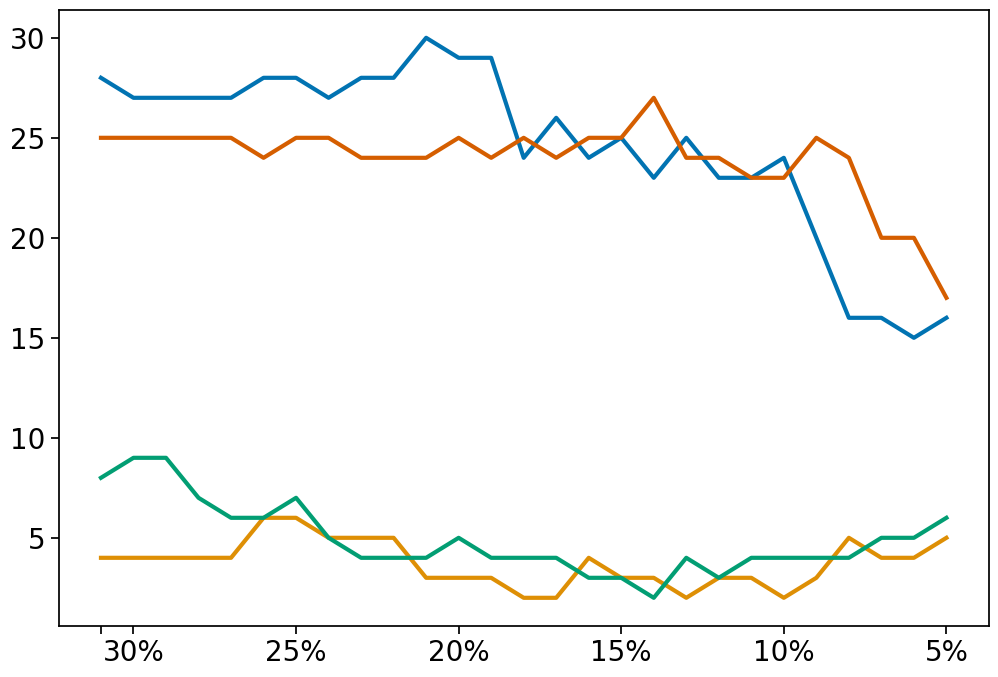

In [41]:
xtick_tick = [0] + np.arange(1,27,5).tolist()
xtick_label = ['', "30%", "25%", "20%", "15%", "10%", "5%"]

palette = sns.color_palette("colorblind")
plt.figure(figsize=(12,8))
sns.lineplot(power_in_house,x="Threshold",y="count_p_values",hue="Infection",palette=palette,linewidth = 3,hue_order=infection_of_interest,legend=False)
plt.xticks(xtick_tick,xtick_label, ha='center',fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title("", fontsize=22)
plt.savefig("./plots/power/in_house.png")
plt.show()

### Simulation

N mice variable

In [42]:
simulation_folder = "./results/simulations/N_mice_variable_THR_fix/"
simulation = import_simulations(simulation_folder)
simulation['Infection'] = simulation['Infection'].replace({"Listeria":"L. monocytogenes"})
infection_of_interest = ["L. monocytogenes","C. albicans","H1N1","S. pneumoniae"]
simulation = simulation[simulation['Infection'].isin(infection_of_interest)]

C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\2919133540.py:3: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.lineplot(simulation,x="N_mice",y="Power",hue="Infection",errorbar='sd',palette=palette,hue_order=infection_of_interest,linewidth = 3,legend=False)


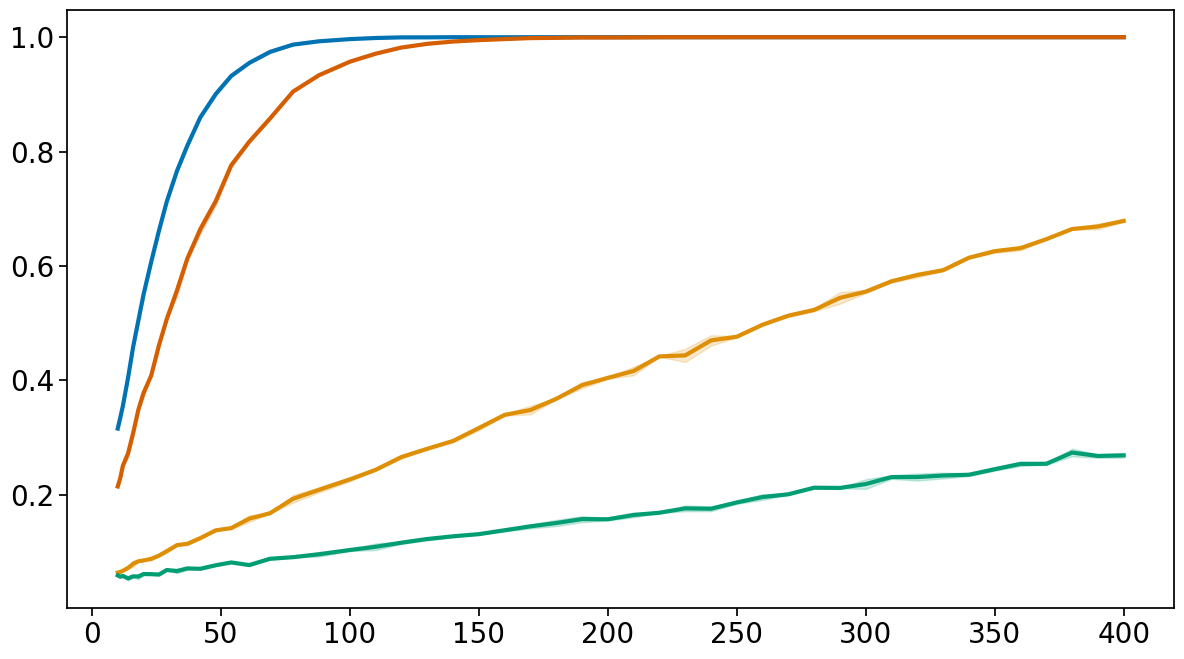

In [43]:
palette = sns.color_palette("colorblind")
plt.figure(figsize=(12,6.75))
ax = sns.lineplot(simulation,x="N_mice",y="Power",hue="Infection",errorbar='sd',palette=palette,hue_order=infection_of_interest,linewidth = 3,legend=False)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('', fontsize=25)
plt.ylabel('', fontsize=25)
plt.title("",fontsize=2)
plt.tight_layout()
plt.savefig("./plots/power/variable_mice.png")
#plt.show()

Threshold variable

In [44]:
fix_n_path = "./results/simulations/N_mice_fix_THR_variable/"
df_fix_N = import_simulations(fix_n_path)
df_fix_N['Infection'] = df_fix_N['Infection'].replace({"Listeria":"L. monocytogenes"})
df_fix_N = df_fix_N[df_fix_N['Infection'].isin(["L. monocytogenes","S. pneumoniae"])]
print(df_fix_N.columns)
print(df_fix_N)
df_fix_N['Power'] = df_fix_N['Power'].astype(float)

Index(['Power', 'Repetition_No', 'N_simulation', 'N_mice', 'Threshold',
       'Infection'],
      dtype='object')
       Power  Repetition_No  N_simulation  N_mice Threshold         Infection
0     0.8000              1          5000      35  original  L. monocytogenes
1     0.8000              2          5000      35  original  L. monocytogenes
2     0.8000              3          5000      35  original  L. monocytogenes
3     0.8000              4          5000      35  original  L. monocytogenes
4     0.8000              5          5000      35  original  L. monocytogenes
...      ...            ...           ...     ...       ...               ...
1075  0.0508             16          5000      56      0.05     S. pneumoniae
1076  0.0508             17          5000      56      0.05     S. pneumoniae
1077  0.0508             18          5000      56      0.05     S. pneumoniae
1078  0.0508             19          5000      56      0.05     S. pneumoniae
1079  0.0508             20

C:\Users\ma7054\AppData\Local\Temp\ipykernel_14696\2613572415.py:11: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_fix_N,x='Threshold',y='Power',hue='Infection',errorbar='sd',palette=palette,linewidth = 3,legend=False)


thr tick ['original', '0.29', '0.27', '0.25', '0.23', '0.21', '0.19', '0.17', '0.15', '0.13', '0.11', '0.09', '0.07', '0.05']


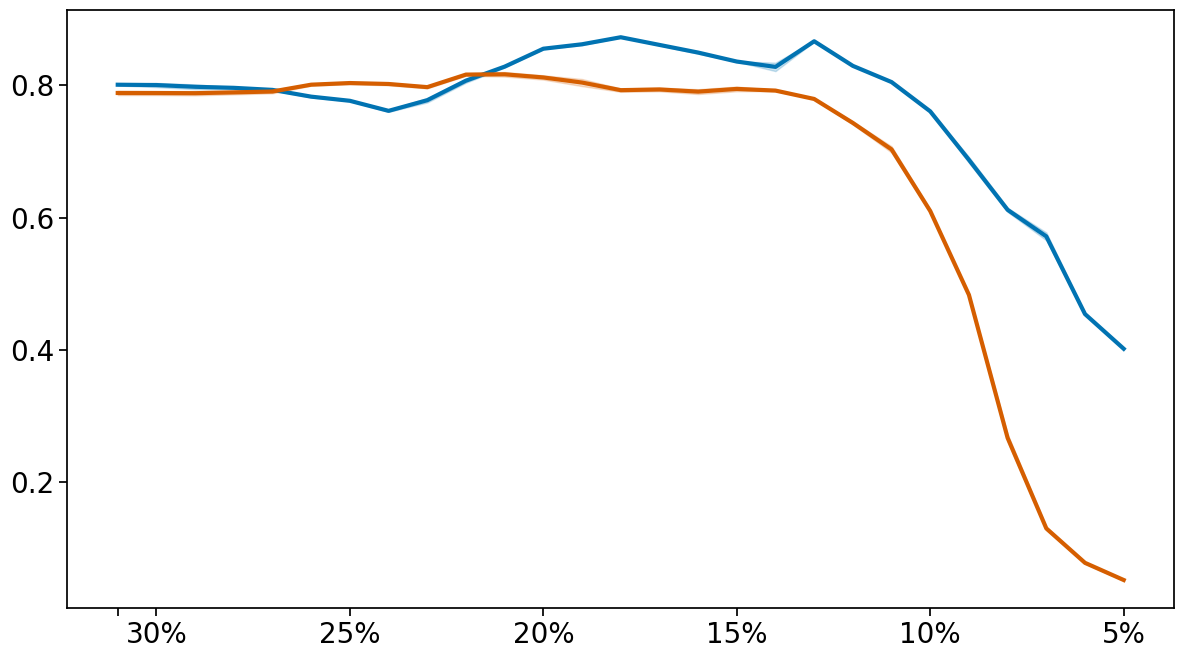

In [45]:
xtick_tick = [0] + np.arange(1,27,5).tolist()
xtick_label = ['', "30%", "25%", "20%", "15%", "10%", "5%"]

palette = sns.color_palette("colorblind")
palette[0] = palette[0]
palette[1] = palette[3]


plt.figure(figsize=(12,6.75))

sns.lineplot(data=df_fix_N,x='Threshold',y='Power',hue='Infection',errorbar='sd',palette=palette,linewidth = 3,legend=False)

thr_tick = df_fix_N['Threshold'].unique().tolist()
thr_tick = thr_tick[::2]
print("thr tick",thr_tick)
plt.xticks(xtick_tick,xtick_label, fontsize=20,ha='center')
plt.yticks(fontsize=20)
plt.xlabel('', fontsize=25)
plt.ylabel('', fontsize=25)
plt.title("",fontsize=2)
plt.tight_layout()
plt.savefig("./plots/power/variable_thr.png")
#plt.show()